In [69]:
import numpy as np
from matplotlib import pyplot as plt
import librosa
import os
import sklearn.preprocessing
from scipy.signal import lfilter, spectrogram, stft
from scipy.fft import rfft, dct

In [2]:
working_dir = os.getcwd()

In [3]:
def get_spectrum(x, fs, N, f_scale='Hz'):
    X = abs(np.fft.fft(x, N))
    X = X[0:N//2]
    f = np.fft.fftfreq(n = N, d = 1/fs)
    f = f[0:N//2]
    if f_scale == 'kHz':
        f = f/1000

    return X, f

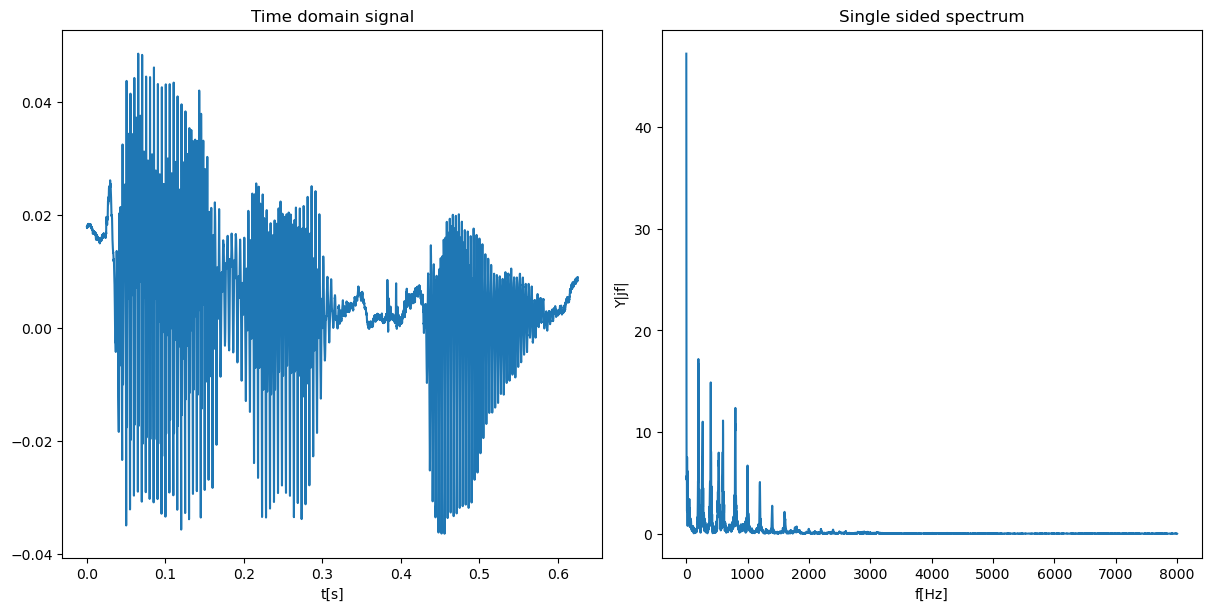

In [4]:
y, fs = librosa.load(os.path.join(working_dir, '..', 'Data','words', 'Speaker_4', 'word_0.wav'), sr=None)
N = len(y)
duration = N/fs
t = np.linspace(0,duration,N)

Y, f = get_spectrum(y, fs, N, f_scale='Hz')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6),
                       layout='constrained')
axs = ax.ravel()
axs[0].plot(t,y)
axs[0].title.set_text('Time domain signal')
axs[0].set_xlabel('t[s]')
axs[1].plot(f,Y)
axs[1].title.set_text('Single sided spectrum')
axs[1].set_xlabel('f[Hz]')
axs[1].set_ylabel('Y|jf|')

plt.show()

#### Pre-emphasis

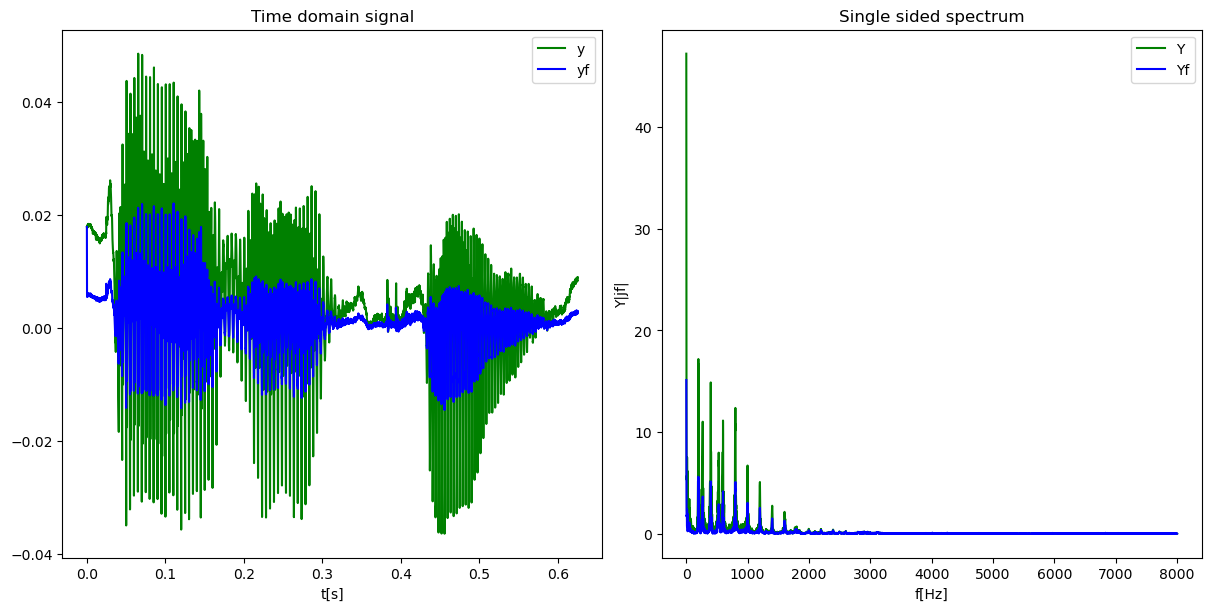

In [5]:
yf = lfilter(b=[1, -0.68], a=1, x=y)

Yf, f = get_spectrum(yf, fs, N, f_scale='Hz')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6),
                       layout='constrained')
axs = ax.ravel()
axs[0].plot(t,y, color='green', label='y')
axs[0].plot(t,yf, color='blue', label='yf')
axs[0].title.set_text('Time domain signal')
axs[0].set_xlabel('t[s]')
axs[0].legend()

axs[1].plot(f,Y, color='green', label='Y')
axs[1].plot(f,Yf, color='blue', label='Yf')
axs[1].title.set_text('Single sided spectrum')
axs[1].set_xlabel('f[Hz]')
axs[1].set_ylabel('Y|jf|')
axs[1].legend()
plt.show()

### MFCC extraction using librosa

In [6]:
window_length = int(30*fs/1000) #30ms window
window_step = int(20*fs/1000) #20ms overlap

In [107]:
mfccs = librosa.feature.mfcc(y=yf, n_mfcc=20,sr=fs, win_length=window_length, hop_length=window_step)
print(mfccs.shape)

(20, 32)


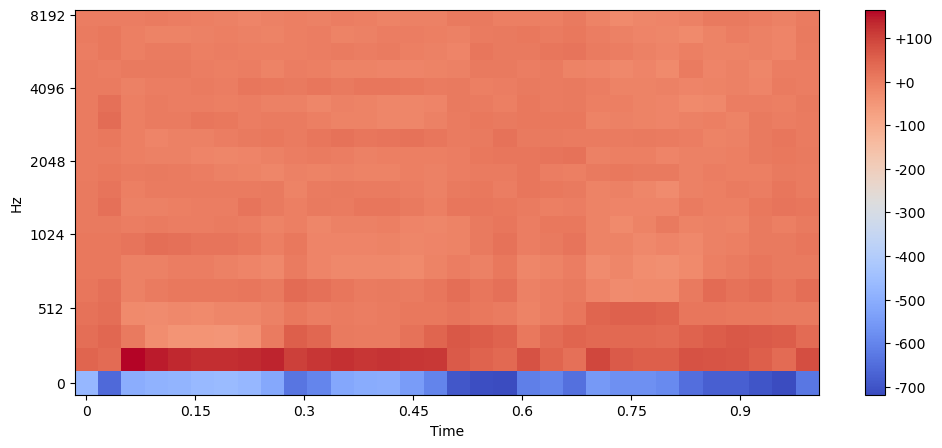

In [108]:
plt.figure(figsize=(12, 5))
librosa.display.specshow(mfccs, 
                         x_axis="time", 
                         y_axis='mel',
                         sr=fs)
plt.colorbar(format="%+2.f")
plt.show()

### Extracting MFCCs manually (for one window)
Instead of observing whole audio sinal, we will observe 30ms frames with overlap of 20ms.

#### Windowing a signal
Most real world audio signals are non-periodic, however, the math of the Fourier transform assumes that the signal being transformed is periodic over the time span in question.
This mismatch between the Fourier assumption of periodicity, and the real world fact that audio signals are generally non-periodic, leads to "spectral leakage", and generally manifest as a wrongful distribution of energy across the power spectrum of the signal.
To reduce the effect of this we apply a tapered window function such as a Hann window which smooths out any such discontinuity

In [9]:
frames = librosa.util.frame(yf, frame_length=window_length, hop_length=window_step)
frames.shape

(480, 30)

In [10]:
windowed_frames = np.hanning(window_length).reshape(-1,1)*frames

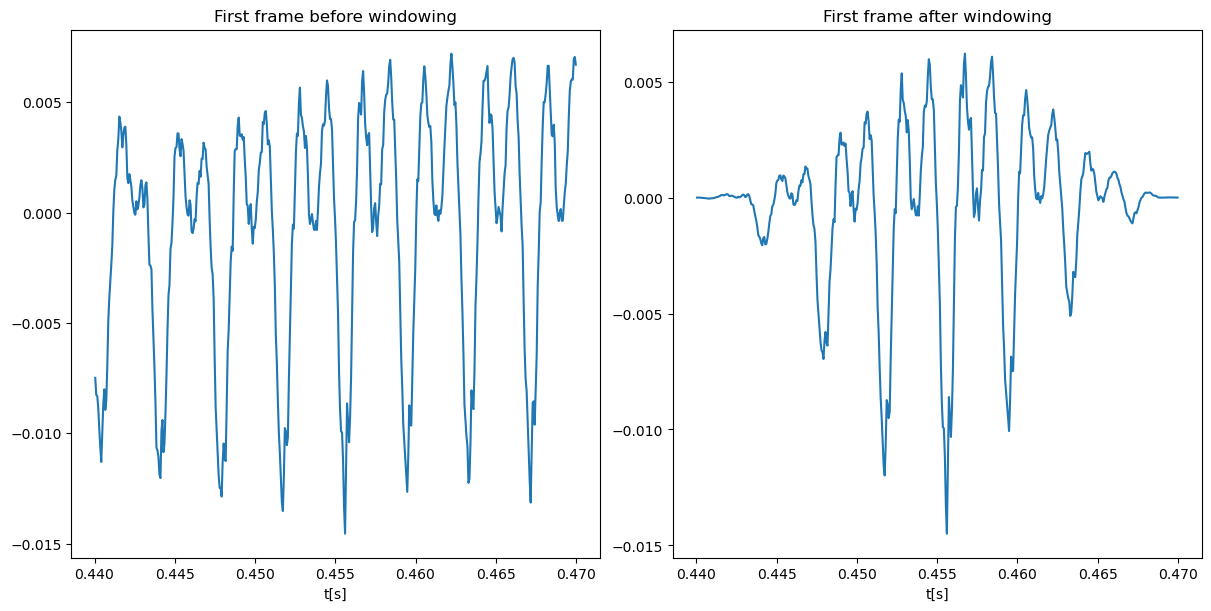

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6),
                       layout='constrained')
axs = ax.ravel()
axs[0].plot(t[22*window_step:22*window_step+window_length],frames[:,22])
axs[0].title.set_text('First frame before windowing')
axs[0].set_xlabel('t[s]')
axs[1].plot(t[22*window_step:22*window_step+window_length], windowed_frames[:,22])
axs[1].title.set_text('First frame after windowing')
axs[1].set_xlabel('t[s]')
plt.show()

#### Cepstrum
MFC is a representation of the short-term power spectrum. The difference of a cepstrum and MFC is that in the MFC the frequency bands are equally spaced on the mel scale, which approximates the human auditory system.

In [12]:
# Time-domain signal
window = windowed_frames[:,22]
t_window = np.linspace(0,30,window_length)

# Spectrum
N_window = window_length
window_spectrum, f_window = get_spectrum(window, fs, N_window, f_scale='kHz')

# Log-spectrum
logspectrum = 20*np.log10(np.abs(window_spectrum))

# Cepstrum
cepstrum = abs(np.fft.fft(logspectrum))
cepstrum = cepstrum[0:N_window//2]
ctime = np.linspace(0,0.5*1000*N_window/fs,len(cepstrum))


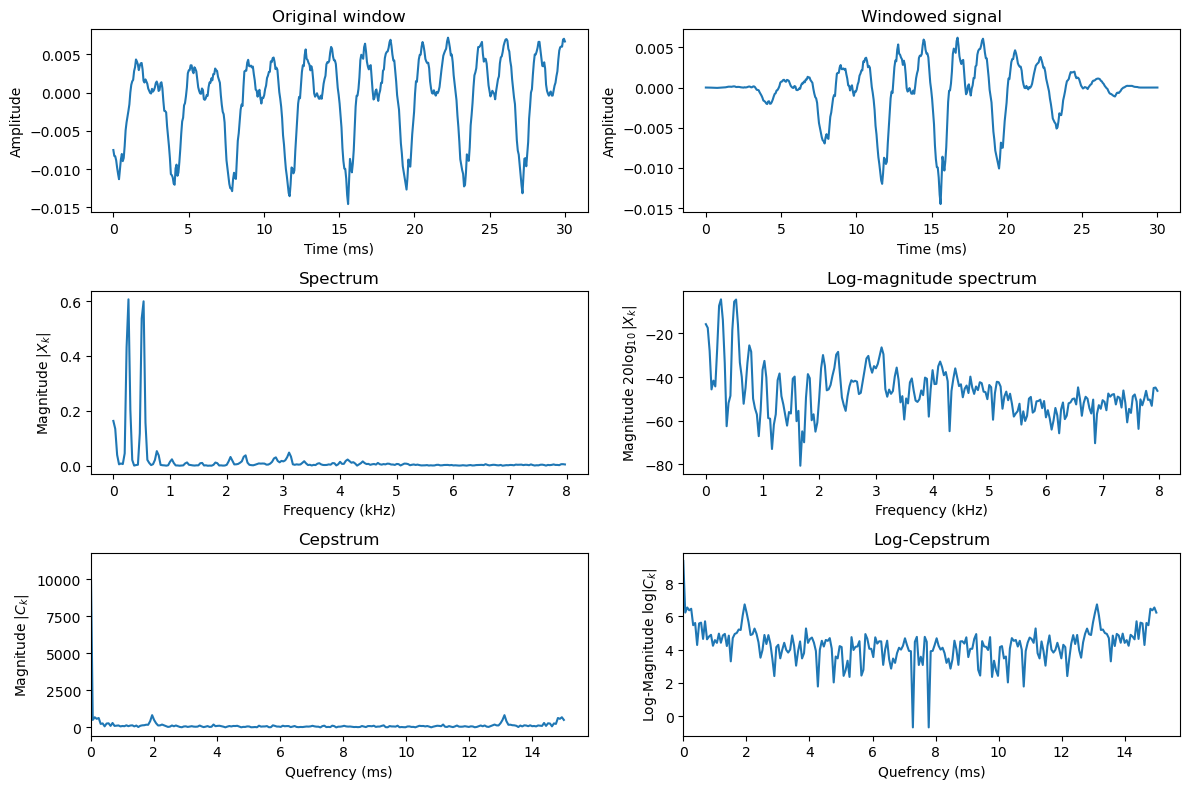

In [13]:
plt.figure(figsize=[12,8])
plt.subplot(321)
plt.plot(t_window[0:window_length], frames[:,22])
plt.title('Original window')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')

plt.subplot(322)
plt.plot(t_window[0:window_length],window)
plt.title('Windowed signal')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')

plt.subplot(323)
plt.plot(f_window,window_spectrum)
plt.title('Spectrum')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Magnitude $|X_k|$')

plt.subplot(324)
plt.plot(f_window,logspectrum)
plt.title('Log-magnitude spectrum')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Magnitude $20\log_{10}|X_k|$')

plt.subplot(325)
plt.plot(ctime,cepstrum)
plt.title('Cepstrum')
plt.xlabel('Quefrency (ms)')
plt.ylabel('Magnitude $|C_k|$')
ax = plt.axis()
ax = [0, ax[1], ax[2], ax[3]]
plt.axis(ax)

plt.subplot(326)
plt.plot(ctime,np.log(cepstrum))
plt.title('Log-Cepstrum')
plt.xlabel('Quefrency (ms)')
plt.ylabel('Log-Magnitude $\log|C_k|$')
ax = plt.axis()
ax = [0, ax[1], ax[2], ax[3]]
plt.axis(ax)
plt.tight_layout()
plt.show()


#### Mel-scale
The cepstrum is good for extracting envelope and F0-information, but it is not particularly efficient in the sense that it has a large number of coefficients for a little amount of information. A solution is to apply smoothing in the power-spectrum. For example, we could use a triangular shape. In heuristic terms, we just take an average of the power around a certain frequency, such that frequencies near have a larger weight than frequencies far away.

However, a downside is that the information does not reflect the importance of features for humans. Taking the log-transform does map magnitudes to a perceptual scale, but the frequency scale is still not mapped to a perceptual domain. The mel-scale is a scale which maps frequencies such that steps between tones align with our perception of steps.

In [14]:
def freq2mel(f): return 2595*np.log10(1 + (f/700))
def mel2freq(m): return 700*(10**(m/2595) - 1)

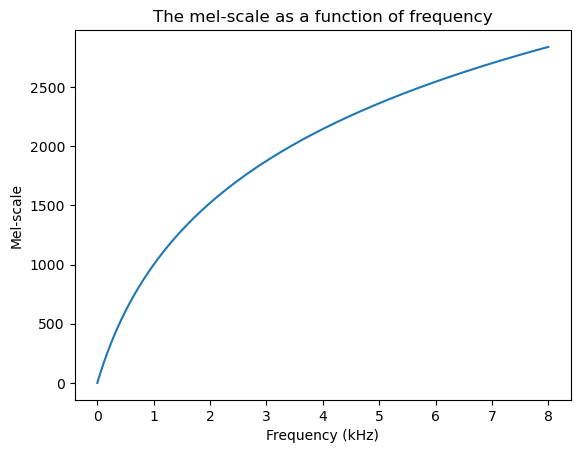

In [15]:
freq = np.linspace(0,8000,1000)

fig, ax = plt.subplots()
ax.plot(freq/1000,freq2mel(freq))
ax.set_xlabel('Frequency (kHz)')
ax.set_ylabel('Mel-scale')
ax.title.set_text('The mel-scale as a function of frequency')
plt.show()

In [16]:
def get_melbank(melbands, maxmel, f, spectrum_len):
    mel_idx = np.linspace(0,maxmel,melbands+2)
    freq_idx = mel2freq(mel_idx)
    k = f*1000
    melfilterbank = np.zeros((spectrum_len,melbands))

    for j in range(1,melbands):
        l_j = freq_idx[j-1]
        c_j = freq_idx[j]
        u_j = freq_idx[j+1]
        upslope = (k-l_j)/(c_j-l_j)
        downslope = (u_j-k)/(u_j-c_j)

        if j==1:
            upslope = 1.0 + 0*k
        if j==melbands-1:
            downslope = 1.0 + 0*k

        melfilterbank[:,j-1] = np.max([0*k,np.min([upslope,downslope],axis=0)],axis=0)

    melreconstruct = np.matmul(np.diag(np.sum(melfilterbank**2+1e-12,axis=0)**-1),np.transpose(melfilterbank))
    return melfilterbank, melreconstruct

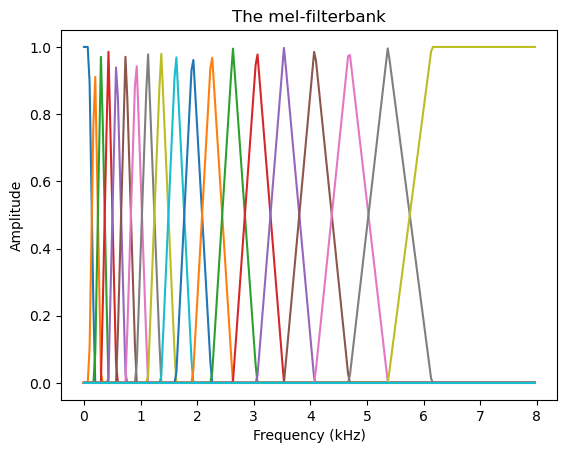

In [17]:
melbands = 20
maxmel = freq2mel(8000)
melfilterbank, melreconstruct = get_melbank(melbands, maxmel, spectrum_len=len(window_spectrum),f=f_window)

plt.figure()
plt.plot(f_window,melfilterbank)
plt.xlabel('Frequency (kHz)')
plt.ylabel('Amplitude')
plt.title('The mel-filterbank')
plt.show()

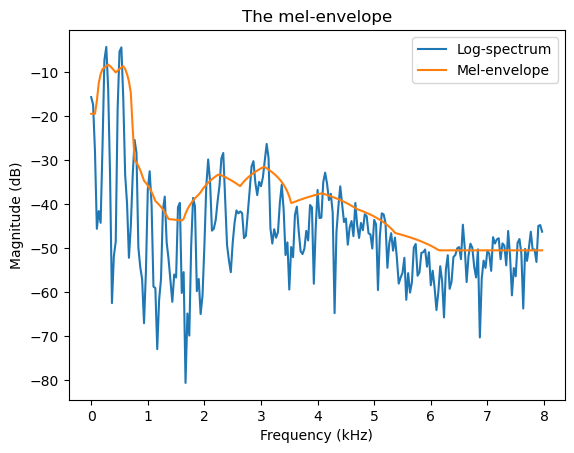

In [18]:
logmelspectrum = 10*np.log10(np.matmul(np.transpose(melfilterbank),np.abs(window_spectrum)**2)+1e-12)
logenvelopespectrum = 10*np.log10(np.matmul(np.transpose(melreconstruct),10**(logmelspectrum/10)))

plt.plot(f_window,logspectrum,label='Log-spectrum')
plt.plot(f_window,logenvelopespectrum,label='Mel-envelope')
plt.legend()
plt.xlabel('Frequency (kHz)')
plt.ylabel('Magnitude (dB)')
plt.title('The mel-envelope')
plt.show()

#### MFCC
A remaining issue with the log-melspectrum is however that neighbouring samples are highly correlated. That is, information is distributed throughout the individual samples. A generic operation for decorrelating sequentially correlated data is the discrete cosine transform (DCT)

In [19]:
mfcc = dct(logmelspectrum)

### MFCC extraction for whole signal

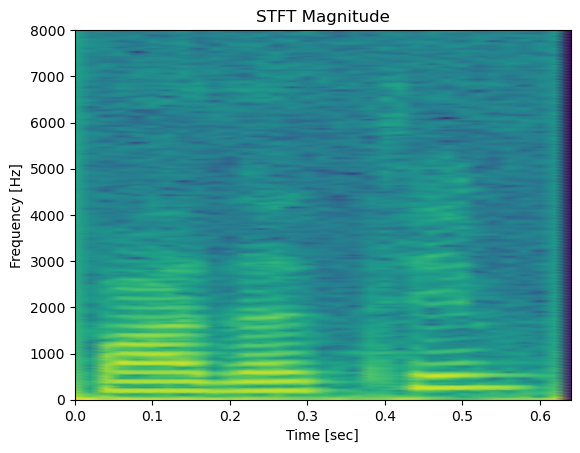

In [95]:
f_spect, t_spect, Sxx = stft(x=y,fs=fs,window='hann',nperseg=window_length,noverlap=window_length-window_step)
plt.pcolormesh(t_spect, f_spect, 20*np.log10(np.abs(Sxx)), shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [96]:
melbands = 20
maxmel = freq2mel(8000)
melfilterbank, melreconstruct = get_melbank(melbands, maxmel, spectrum_len=Sxx.shape[0] ,f=f_spect/1000)

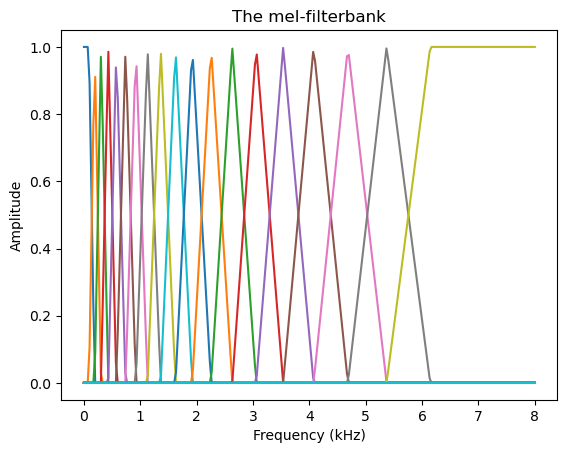

In [97]:
plt.figure()
plt.plot(f_spect/1000,melfilterbank)
plt.xlabel('Frequency (kHz)')
plt.ylabel('Amplitude')
plt.title('The mel-filterbank')
plt.show()

In [98]:
logmelspectrogram = np.log(np.matmul((np.abs(Sxx)**2).T,melfilterbank)+1e-12)
mfcc = dct(logmelspectrogram)

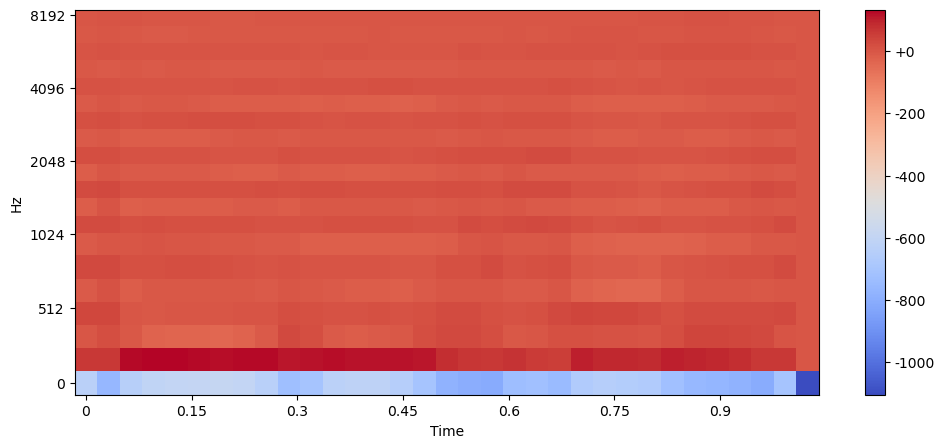

In [99]:
plt.figure(figsize=(12, 5))
librosa.display.specshow(mfcc.T, 
                         x_axis="time", 
                         y_axis='mel',
                         sr=fs)
plt.colorbar(format="%+2.f")
plt.show()